In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [3]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [12]:
weight_decay = 0.0001
batch_size = 128
num_epochs = 5
dropout_rate = 0.2
image_size = 64  # We'll resize input images to this size.
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")


Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


In [5]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)


In [6]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history


In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


2022-02-09 00:35:40.752441: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 153600000 exceeds 10% of free system memory.


In [9]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

In [10]:
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x


In [13]:
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
history = run_experiment(mlpmixer_classifier)

2022-02-09 00:37:05.496789: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 138240000 exceeds 10% of free system memory.


Epoch 1/5
352/352 [==============================] - 200s 562ms/step - loss: 3.8765 - acc: 0.1098 - top5-acc: 0.3114 - val_loss: 3.6017 - val_acc: 0.1620 - val_top5-acc: 0.4102 - lr: 0.0050
Epoch 2/5
352/352 [==============================] - 207s 588ms/step - loss: 3.3815 - acc: 0.1882 - top5-acc: 0.4602 - val_loss: 3.2637 - val_acc: 0.2138 - val_top5-acc: 0.4992 - lr: 0.0050
Epoch 3/5
352/352 [==============================] - 205s 581ms/step - loss: 3.1859 - acc: 0.2234 - top5-acc: 0.5092 - val_loss: 3.1046 - val_acc: 0.2530 - val_top5-acc: 0.5488 - lr: 0.0050
Epoch 4/5
352/352 [==============================] - 197s 560ms/step - loss: 3.0409 - acc: 0.2508 - top5-acc: 0.5474 - val_loss: 2.9145 - val_acc: 0.2812 - val_top5-acc: 0.5932 - lr: 0.0050
Epoch 5/5
  3/313 [..............................] - ETA: 10s - loss: 2.8868 - acc: 0.3229 - top5-acc: 0.6146

2022-02-09 00:53:51.193446: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.


313/313 [==============================] - 11s 34ms/step - loss: 2.9339 - acc: 0.2923 - top5-acc: 0.5788
Test accuracy: 29.23%
Test top 5 accuracy: 57.88%


In [16]:
xaxis = [*range(1,6,1)]

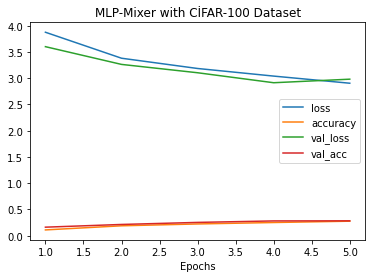

In [18]:
import matplotlib.pyplot as plt

x_data = xaxis
y_data = history.history['val_acc']
y_data2 = history.history["loss"]
y_data3 = history.history['acc']
y_data4 = history.history['val_loss']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(x_data, y_data2, label='loss')
ax.plot(x_data, y_data3, label='accuracy')
ax.plot(x_data, y_data4, label='val_loss')
ax.plot(x_data, y_data, label="val_acc")


plt.xlabel("Epochs")
plt.ylabel("")
plt.title("MLP-Mixer with CİFAR-100 Dataset")

plt.legend()

plt.show()

In [14]:
history.history.keys()

dict_keys(['loss', 'acc', 'top5-acc', 'val_loss', 'val_acc', 'val_top5-acc', 'lr'])

In [19]:
mlpmixer_classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 64, 64, 3)        7         
 al)                                                             
                                                                 
 patches_1 (Patches)         (None, 64, 192)           0         
                                                                 
 dense_34 (Dense)            (None, 64, 256)           49408     
                                                                 
 sequential_17 (Sequential)  (None, 64, 256)           167680    
                                                                 
 global_average_pooling1d_1   (None, 256)              0         
 (GlobalAveragePooling1D)                                  